## Learning Inverse Kinematics

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt


2024-03-28 10:06:00.124402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 10:06:00.124432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 10:06:00.125381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 10:06:00.130554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 10:06:00.701876: W tensorflow/compiler/tf2

In [2]:
# Load the data
with open('dataset/data1.json') as f:
    data = json.load(f)

df = pd.json_normalize(data['data'])
# df.head()

In [3]:
X = df.drop('actions', axis=1)
y = pd.DataFrame(df['actions'].to_list())  # Assuming 'actions' is a list
# X_flat = X.apply(lambda x: pd.Series([i for _list in x for i in _list]), axis=1)

ee_position = pd.DataFrame(X['end-effector-position'].tolist(), columns=['ee_pos_x', 'ee_pos_y', 'ee_pos_z'])
X = pd.concat([X.drop('end-effector-position', axis=1), ee_position], axis=1)

# Flatten 'end-effector-orientation' column
ee_orientation = pd.DataFrame(X['end-effector-orientation'].tolist(), columns=['ee_ori_w', 'ee_ori_x', 'ee_ori_y', 'ee_ori_z'])
X = pd.concat([X.drop('end-effector-orientation', axis=1), ee_orientation], axis=1)

# y_flat = y.apply(lambda x: pd.Series([i for _list in x for i in _list]), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# df = pd.json_normalize(data['data'])
X = df.drop('actions', axis=1)
y = pd.DataFrame(df['actions'].to_list())  # Assuming 'actions' is a list
ee_position = pd.DataFrame(X['end-effector-position'].tolist(), columns=['ee_pos_x', 'ee_pos_y', 'ee_pos_z'])
ee_position = ee_position[['ee_pos_z', 'ee_pos_y', 'ee_pos_x']]
# swap z and x columns
# ee_position = ee_position[['ee_pos_z', 'ee_pos_y', 'ee_pos_x']]
X = pd.concat([X.drop('end-effector-position', axis=1), ee_position], axis=1)
ee_orientation = pd.DataFrame(X['end-effector-orientation'].tolist(), columns=['ee_ori_w', 'ee_ori_x', 'ee_ori_y', 'ee_ori_z'])
X = pd.concat([X.drop('end-effector-orientation', axis=1), ee_orientation], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train["ee_pos_z"].min(), X_train["ee_pos_z"].max()

(0.7352330271622212, 2.264840688795799)

In [5]:
X_train.head()

,shoulder-link-output,bicep-link-output,forearm-link-output,sphericalWrist1-link-output,sphericalWrist2-link-output,bracelet-link-output,ee_pos_z,ee_pos_y,ee_pos_x,ee_ori_w,ee_ori_x,ee_ori_y,ee_ori_z
87001,2.765674,-0.565908,-0.099882,2.547717,0.403470,1.834209,2.164661,0.116567,0.354645,0.028615,-0.889563,0.438860,0.123533
173935,-0.509322,0.827521,1.354675,-1.896621,1.690225,2.988733,1.999233,0.007581,0.196817,-0.434517,0.726513,-0.025139,-0.531734
87050,-2.531133,1.629018,0.726187,2.472186,0.274473,-1.760225,1.656677,0.411173,-0.617123,0.524121,0.489399,0.689316,0.103100
147371,-0.432982,-1.721859,2.037558,-3.122164,-1.368832,-1.174280,1.165610,-0.054600,-0.124025,0.512086,0.605594,-0.578956,-0.189299
231707,1.275059,1.940230,2.516941,2.910414,-0.155763,0.396523,1.631867,-0.141587,0.040263,-0.311701,-0.612376,-0.705606,0.173087


In [42]:
random_index = np.random.randint(0, len(X_train)-1)
data_obs = np.array(X_train[random_index:random_index+1])
data_action = np.array(y_train[random_index:random_index+1])

if True:
    data_obs[0][6] = data_obs[0][6] + np.random.uniform(-0.7, 0)
    # pass

data_obs = np.reshape(data_obs, (data_obs.shape[1],))
data_ee_target = data_obs[6:]
data_action = np.reshape(data_action, (data_action.shape[1],))

In [44]:
np.random.sample([True, False])

TypeError: an integer is required

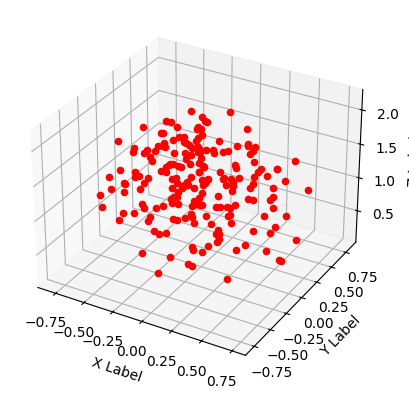

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(200):
    random_index = np.random.randint(0, len(X_train)-1)
    data_obs = np.array(X_train[random_index:random_index+1])
    data_action = np.array(y_train[random_index:random_index+1])

    if True:
        data_obs[0][6] = data_obs[0][6] + np.random.uniform(-0.7, 0)
        # pass

    data_obs = np.reshape(data_obs, (data_obs.shape[1],))
    data_ee_target = data_obs[6:]
    data_action = np.reshape(data_action, (data_action.shape[1],))
    # plot 3d x, y, z

    
    
    ax.scatter(data_ee_target[1], data_ee_target[2], data_ee_target[0], c='r', marker='o')
    # ax.scatter(data_action[0], data_action[1], data_action[2], c='b', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

In [43]:
data_obs[6:9]

array([ 0.47527102, -0.04462336, -0.69043265])

In [20]:
X_train["ee_pos_z"].min(), X_train["ee_pos_z"].max()


(0.7352330271622212, 2.264840688795799)

In [11]:
# Define the neural network
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(y.columns), activation='linear'))  # Assuming 'actions' is a list

# Define the learning rate schedule
def scheduler(epoch, lr):
    if epoch < 75:
        return lr
    else:
        return lr * 0.6

# Create a LearningRateScheduler callback
callback = LearningRateScheduler(scheduler)


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


2024-02-24 16:35:54.106999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 16:35:54.285763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 16:35:54.286029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
# Train the model
# y_train_array = np.array(y_train.tolist())
history = model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=200, batch_size=512, callbacks=[callback])



Epoch 1/200


2024-02-24 16:36:01.734593: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-24 16:36:02.048580: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7bad608b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 16:36:02.048599: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-02-24 16:36:02.061303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-24 16:36:02.091657: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1708810562.147225  275384 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/507 [==============================] - 2s 2ms/step - loss: 0.0381 - accuracy: 0.9614 - lr: 0.0010
Epoch 2/200
507/507 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.9802 - lr: 0.0010
Epoch 3/200
507/507 [==============================] - 1s 1ms/step - loss: 0.0016 - accuracy: 0.9823 - lr: 0.0010
Epoch 4/200
507/507 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 0.9829 - lr: 0.0010
Epoch 5/200
507/507 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9833 - lr: 0.0010
Epoch 6/200
507/507 [==============================] - 1s 1ms/step - loss: 0.0013 - accuracy: 0.9844 - lr: 0.0010
Epoch 7/200
507/507 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9849 - lr: 0.0010
Epoch 8/200
507/507 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9850 - lr: 0.0010
Epoch 9/200
507/507 [==============================] - 1s 2ms/step - loss: 0.0011 - accuracy: 0.9861

2027/2027 [==============================] - 2s 774us/step - loss: 4.6913e-04 - accuracy: 0.9948
Test loss: 0.0004691340436693281
Test accuracy: 0.9948198795318604


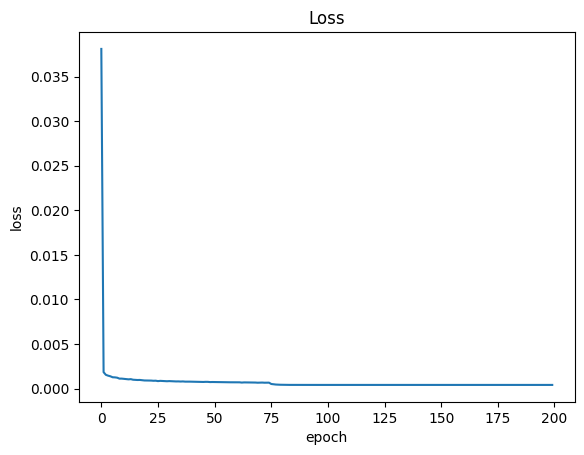

In [15]:
# validate the model
y_test_pred = model.predict(X_test.to_numpy())
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y.columns)
y_test_pred_df = y_test_pred_df.round(2)
y_test_pred_df = y_test_pred_df.clip(0, 1)

# Evaluate the model
score = model.evaluate(X_test.to_numpy(), y_test.to_numpy())
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# Plot the loss
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


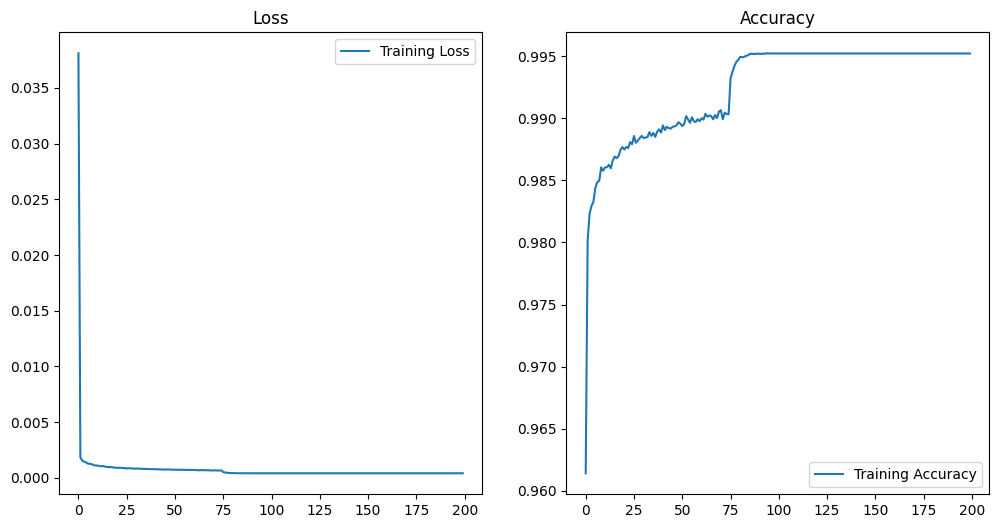

In [14]:
# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)

1193/1193 [==============================] - 1s 758us/step - loss: 9.4644e-07 - accuracy: 0.9912
Test loss: 9.464371828471485e-07


In [17]:
# Save the model
model.save('ik_model/modelv1_256.h5')

# Later, load the model
from tensorflow.keras.models import load_model

loaded_model = load_model('ik_model/modelv1_256.h5')

### validate with sim

In [1]:
import numpy as np
import mujoco
from model_arm_data import *
import mujoco.viewer
import mujoco_viewer
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import json
import pandas as pd

dataset_path = "tmp.json"

Model = ArmEnv(render_mode='human', datafile=dataset_path)
ik_model = load_model('ik_model/modelv1_256.h5')

# Load the data
with open('dataset/data1.json') as f:
    data = json.load(f)

df = pd.json_normalize(data['data'])

X = df.drop('actions', axis=1)
y = pd.DataFrame(df['actions'].to_list())  # Assuming 'actions' is a list
ee_position = pd.DataFrame(X['end-effector-position'].tolist(), columns=['ee_pos_x', 'ee_pos_y', 'ee_pos_z'])
X = pd.concat([X.drop('end-effector-position', axis=1), ee_position], axis=1)
ee_orientation = pd.DataFrame(X['end-effector-orientation'].tolist(), columns=['ee_ori_w', 'ee_ori_x', 'ee_ori_y', 'ee_ori_z'])
X = pd.concat([X.drop('end-effector-orientation', axis=1), ee_orientation], axis=1)
# y_flat = y.apply(lambda x: pd.Series([i for _list in x for i in _list]), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# model = Model.model
# data = Model.data



2024-02-24 17:29:01.757378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 17:29:01.757409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 17:29:01.758414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 17:29:01.763466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-24 17:29:02.341036: W tensorflow/compiler/tf2

In [5]:
# eval for 10 datapoints

data_nums = 10
l2_error_pos = []
l2_error_ori = []

for data_idx in range(data_nums):
    action = ik_model.predict(X_test[data_idx:data_idx+1])[0]
    pred_obs = np.array(X_test[data_idx:data_idx+1])
    # done = False
    Model.reset_model()
    # while not done:
        #     actuator_pos = np.random.uniform(actuator_low_lim, actuator_high_lim, actuator_num)
        #     _, _, done,_ = model.step(action=actuator_pos)
    print("desired pose", pred_obs[0][0:3])
    ee_pos, ee_ori = Model.run_action_data_collection(action)
    # true_obs = Model.get_observations()
    # if done:
    pred_ee_pos = pred_obs[0][6:9]
    true_ee_pos = ee_pos[0:3]

    pred_ee_ori = pred_obs[0][9:]
    true_ee_ori = ee_ori

    l2_error_pos.append(np.linalg.norm(pred_ee_pos - true_ee_pos))
    l2_error_ori.append(np.linalg.norm(pred_ee_ori - true_ee_ori))

    print("Error pos: ", np.linalg.norm(pred_ee_pos - true_ee_pos), "Error ori: ", np.linalg.norm(pred_ee_ori - true_ee_ori))
    print("Done")
    # break

print("Average L2 Error pos: ", np.mean(l2_error_pos), "Average L2 Error pos: ",  np.mean(l2_error_ori))



1/1 [==============================] - 0s 17ms/step


desired pose [-2.46704434  1.65001118  0.47289859]
Error pos:  0.006554418372889952 Error ori:  0.0019894577504518426
Done
1/1 [==============================] - 0s 12ms/step
desired pose [-0.8575612  -2.3009748   1.17985004]
Error pos:  0.0034499354636393464 Error ori:  0.004457416694518995
Done
1/1 [==============================] - 0s 13ms/step
desired pose [ 0.75440179 -0.95312541  1.64742154]
Error pos:  0.0018843147881144797 Error ori:  0.002702527379324821
Done
1/1 [==============================] - 0s 13ms/step
desired pose [ 0.15766137 -1.11869544 -0.85190573]
Error pos:  0.0017409635715818527 Error ori:  0.002952795776251759
Done
1/1 [==============================] - 0s 13ms/step
desired pose [-2.84930359 -0.69356357 -0.45565186]
Error pos:  0.001137360437852159 Error ori:  0.0020913280308266008
Done
1/1 [==============================] - 0s 12ms/step
desired pose [3.07868409 2.03725815 2.00084048]
Error pos:  0.0020419256179935066 Error ori:  0.0032757819915290236
Done
1/1 

In [3]:
action = model.predict(X_test[6:7])[0]
pred_obs = np.array(X_test[6:7])

done = False
Model.reset()
while not done:
    #     actuator_pos = np.random.uniform(actuator_low_lim, actuator_high_lim, actuator_num)
    #     _, _, done,_ = model.step(action=actuator_pos)
    done = Model.run_action_data_collection(action, run_once = True)
    true_obs = Model.get_observations()
    if done:
        print("Done")
        break
    # break

1/1 [==============================] - 0s 10ms/step


writing to file


 action:  [-0.14616337 -0.02987706 -0.0856328   0.07326405 -0.10873747 -0.06219772]
observations written to file
Done


In [5]:
pred_ee_pos = pred_obs[0][0:3]
true_ee_pos = true_obs[0:3]
print("Predicted EE Pos: ", pred_ee_pos)
print("True EE Pos: ", true_ee_pos)
# error
print("Error: ", np.linalg.norm(pred_ee_pos - true_ee_pos))

Predicted EE Pos:  [-0.63756269  0.1284963   0.06231349]
True EE Pos:  [-0.63880825  0.13186927  0.06800195]
Error:  0.006729549999199817


In [1]:
### TEST###

In [10]:
from gymnasium import *
import numpy as np

observation_space = spaces.Dict(
			spaces={
				"observation":
				spaces.Box(low=-np.inf, high=np.inf, shape=(26,), dtype=np.float64)
                },
		seed=None)

# observation_space=spaces.Box(low=-np.inf, high=np.inf, shape=(26,), dtype=np.float64)

In [12]:
observation_space.keys()

KeysView(OrderedDict([('observation', Box(-inf, inf, (26,), float64))]))

In [20]:
obs = np.random.rand(26)
from typing import Dict

obs = [Dict(['observation', obs.tolist()])]

TypeError: Type Dict cannot be instantiated; use dict() instead

In [16]:
type(obs[0])

dict